# Galaxy Bias and Observational Noise

This notebook demonstrates how to transform evolved matter density fields into observed galaxy fields using:
1. **Kaiser model** (linear bias + RSD in Fourier space)
2. **Lagrangian Bias Expansion** (LBE) with higher-order terms
3. **Redshift-Space Distortions** (RSD)
4. **Observational noise**

**Key references:**
- [Modi et al. 2020](http://arxiv.org/abs/1910.07097) - Lagrangian bias expansion
- [Kaiser 1987](https://ui.adsabs.harvard.edu/abs/1987MNRAS.227....1K) - RSD in linear theory


In [1]:
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import numpy as np
from jaxpm.painting import cic_paint

from desi_cmb_fli.bricks import (
    Planck18,
    kaiser_model,
    lagrangian_weights,
    lin_power_mesh,
    rsd,
    safe_div,
)
from desi_cmb_fli.nbody import lpt
from desi_cmb_fli.utils import rg2cgh

jax.config.update("jax_enable_x64", True)
print(f"JAX version: {jax.__version__}")
print(f"JAX devices: {jax.devices()}")
print(f"Using device: {jax.devices()[0].device_kind}")

/pscratch/sd/j/jhawla/envs/desi-cmb-fli/lib/python3.11/site-packages/jax_cosmo/__init__.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
ERROR:2025-10-31 07:00:04,166:jax._src.xla_bridge:473: Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/pscratch/sd/j/jhawla/envs/desi-cmb-fli/lib/python3.11/site-packages/jax_plugins/xla_cuda12/__init__.py", line 201, in _version_check
    version = get_version()
              ^^^^^^^^^^^^^
RuntimeError: jaxlib/cuda/versions_helpers.cc:81: operation cusparseGetProperty(MAJOR_VERSION, &major) failed: The cuSPARSE library was not found.

The above exception was the direct cause of the following exception:



JAX version: 0.8.0
JAX devices: [CpuDevice(id=0)]
Using device: cpu


## 1. Setup: Generate Evolved Matter Field

We start from an evolved matter density field at a=0.5 (z=1) using 2LPT.

In [2]:
# Cosmology
cosmo = Planck18()
cosmo._workspace = {}

# Simulation parameters
box_size = 200.0  # Mpc/h
N = 8  # 2^N = 64^3 grid
mesh_shape = np.array([2**N, 2**N, 2**N])
box_shape = np.array([box_size, box_size, box_size])
a_obs = 0.5  # z ≈ 1
seed = 123

print(f"Box: {box_size} (Mpc/h)^3 with {mesh_shape} grid")
print(f"Cell size: {box_size / mesh_shape[0]:.2f} Mpc/h")
print(f"Observation redshift: z = {1 / a_obs - 1:.2f}")

# Generate initial conditions at a=1
pmesh = lin_power_mesh(cosmo, mesh_shape, box_shape, a=1.0)
transfer = jnp.sqrt(pmesh)

key = jr.PRNGKey(seed)
gaussian_real = jr.normal(key, shape=mesh_shape)
gaussian_k = rg2cgh(gaussian_real)
delta_k_init = gaussian_k * transfer

# Evolve with 2LPT
pos_init = jnp.indices(mesh_shape, dtype=float).reshape(3, -1).T

cosmo_lpt = Planck18()
cosmo_lpt._workspace = {}
dpos_lpt, vel_lpt = lpt(cosmo_lpt, delta_k_init, pos_init, a=a_obs, order=2)
pos_lpt = (pos_init + dpos_lpt) % mesh_shape

print(f"\nEvolved {len(pos_lpt):,} particles with 2LPT")
print(f"Mean displacement: {jnp.mean(jnp.linalg.norm(dpos_lpt, axis=1)):.3f} cells")

Box: 200.0 (Mpc/h)^3 with [256 256 256] grid
Cell size: 0.78 Mpc/h
Observation redshift: z = 1.00

Evolved 16,777,216 particles with 2LPT
Mean displacement: 6.975 cells


## 2. Kaiser Model (Linear Approximation)

The Kaiser model is the simplest approach: linear bias + RSD in Fourier space.

$$\delta_g(\mathbf{k}) = (b + f \mu^2) \delta_m(\mathbf{k})$$

where $\mu = \hat{\mathbf{k}} \cdot \hat{\mathbf{n}}$ is the cosine of the angle between k-mode and line-of-sight.

In [3]:
# Bias parameter and line-of-sight
b1 = 1.5  # Linear Eulerian bias
los = np.array([0.0, 0.0, 1.0])  # z-axis

# Kaiser model without RSD
cosmo_kaiser1 = Planck18()
cosmo_kaiser1._workspace = {}
gxy_kaiser_no_rsd = kaiser_model(cosmo_kaiser1, a_obs, bE=b1, init_mesh=delta_k_init, los=None)

# Kaiser model with RSD
cosmo_kaiser2 = Planck18()
cosmo_kaiser2._workspace = {}
gxy_kaiser_rsd = kaiser_model(cosmo_kaiser2, a_obs, bE=b1, init_mesh=delta_k_init, los=los)

print(
    f"Kaiser without RSD: δ_g ∈ [{jnp.min(gxy_kaiser_no_rsd) - 1:.2f}, {jnp.max(gxy_kaiser_no_rsd) - 1:.2f}]"
)
print(
    f"Kaiser with RSD:    δ_g ∈ [{jnp.min(gxy_kaiser_rsd) - 1:.2f}, {jnp.max(gxy_kaiser_rsd) - 1:.2f}]"
)

Kaiser without RSD: δ_g ∈ [-16.29, 17.39]
Kaiser with RSD:    δ_g ∈ [-19.81, 21.10]


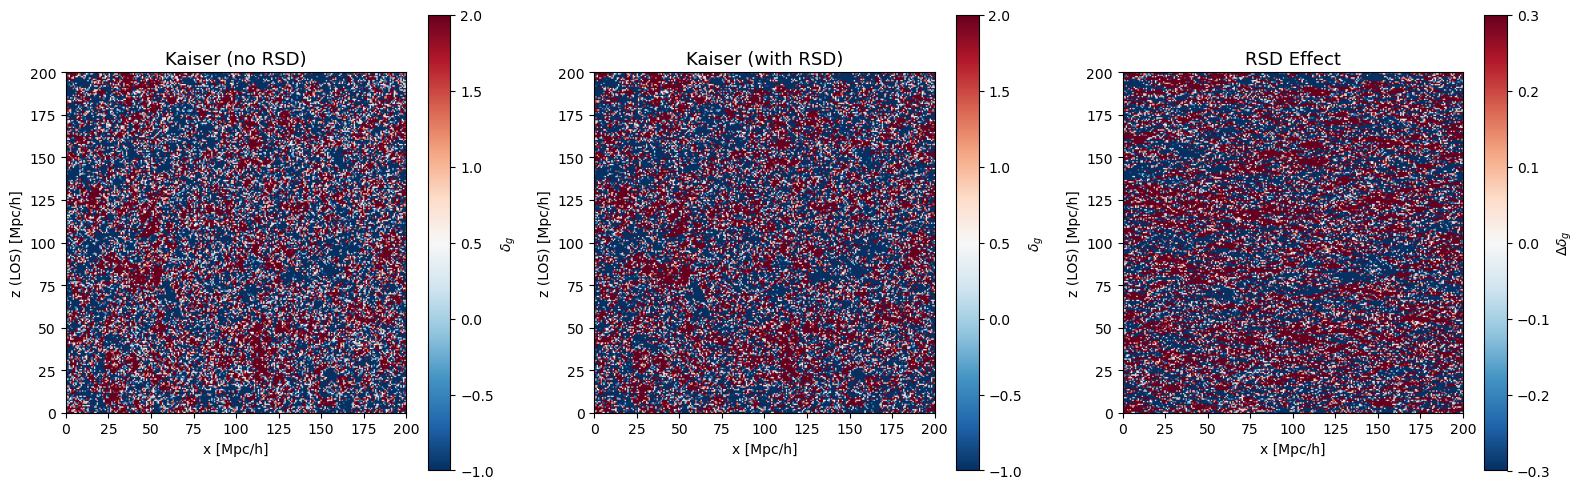

In [4]:
# Visualize difference
slice_y = mesh_shape[1] // 2

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
vmin, vmax = -1.0, 2.0

im0 = axes[0].imshow(
    np.array(gxy_kaiser_no_rsd[:, slice_y, :] - 1).T,
    origin="lower",
    cmap="RdBu_r",
    vmin=vmin,
    vmax=vmax,
    extent=[0, box_size, 0, box_size],
)
axes[0].set_title("Kaiser (no RSD)", fontsize=13)
axes[0].set_xlabel("x [Mpc/h]")
axes[0].set_ylabel("z (LOS) [Mpc/h]")
plt.colorbar(im0, ax=axes[0], label=r"$\delta_g$")

im1 = axes[1].imshow(
    np.array(gxy_kaiser_rsd[:, slice_y, :] - 1).T,
    origin="lower",
    cmap="RdBu_r",
    vmin=vmin,
    vmax=vmax,
    extent=[0, box_size, 0, box_size],
)
axes[1].set_title("Kaiser (with RSD)", fontsize=13)
axes[1].set_xlabel("x [Mpc/h]")
axes[1].set_ylabel("z (LOS) [Mpc/h]")
plt.colorbar(im1, ax=axes[1], label=r"$\delta_g$")

# Difference
diff = gxy_kaiser_rsd - gxy_kaiser_no_rsd
im2 = axes[2].imshow(
    np.array(diff[:, slice_y, :]).T,
    origin="lower",
    cmap="RdBu_r",
    vmin=-0.3,
    vmax=0.3,
    extent=[0, box_size, 0, box_size],
)
axes[2].set_title("RSD Effect", fontsize=13)
axes[2].set_xlabel("x [Mpc/h]")
axes[2].set_ylabel("z (LOS) [Mpc/h]")
plt.colorbar(im2, ax=axes[2], label=r"$\Delta \delta_g$")

plt.tight_layout()
plt.show()

## 3. Lagrangian Bias Expansion (Non-Linear)

For more accurate modeling, we use Lagrangian bias expansion [Modi+2020]:

$$w(\mathbf{q}) = 1 + b_1 \delta + b_2(\delta^2 - \langle\delta^2\rangle) + b_{s^2}(s^2 - \langle s^2\rangle) + b_{\nabla^2}\nabla^2\delta$$

where particles are weighted by $w$ when painting to the grid.

In [5]:
# Lagrangian bias parameters
bias_params = {
    "b1": 1.5,  # Linear bias
    "b2": -0.5,  # Second-order bias
    "bs2": 0.2,  # Tidal bias
    "bn2": -0.1,  # Non-local bias
}

# Compute LBE weights
cosmo_lbe = Planck18()
cosmo_lbe._workspace = {}
weights = lagrangian_weights(
    cosmo_lbe, a_obs, pos_init, box_shape, **bias_params, init_mesh=delta_k_init
)

print("LBE weights statistics:")
print(f"  Mean:   {jnp.mean(weights):.3f}")
print(f"  Std:    {jnp.std(weights):.3f}")
print(f"  Min:    {jnp.min(weights):.3f}")
print(f"  Max:    {jnp.max(weights):.3f}")
print(f"  Negatives: {jnp.sum(weights < 0)} / {len(weights)}")

LBE weights statistics:
  Mean:   2.827
  Std:    2.557
  Min:    0.000
  Max:    14.050
  Negatives: 0 / 16777216


In [8]:
# Paint particles with different bias models
# 1. No bias (matter field)
density_matter = cic_paint(jnp.zeros(mesh_shape), pos_lpt)
density_matter = density_matter / jnp.mean(density_matter) - 1

# 2. Linear bias: use only b1 term in LBE
cosmo_linear = Planck18()
cosmo_linear._workspace = {}
weights_linear = lagrangian_weights(
    cosmo_linear,
    a_obs,
    pos_init,
    box_shape,
    b1=bias_params["b1"],
    b2=0.0,
    bs2=0.0,
    bn2=0.0,
    init_mesh=delta_k_init,
)
density_linear = cic_paint(jnp.zeros(mesh_shape), pos_lpt, weights_linear)
density_linear = density_linear / jnp.mean(density_linear) - 1

# 3. Full LBE
density_lbe = cic_paint(jnp.zeros(mesh_shape), pos_lpt, weights)
density_lbe = density_lbe / jnp.mean(density_lbe) - 1

print("\nDensity field statistics:")
print(f"Matter:            δ ∈ [{jnp.min(density_matter):.2f}, {jnp.max(density_matter):.2f}]")
print(f"Linear bias (LBE): δ ∈ [{jnp.min(density_linear):.2f}, {jnp.max(density_linear):.2f}]")
print(f"Full LBE:          δ ∈ [{jnp.min(density_lbe):.2f}, {jnp.max(density_lbe):.2f}]")


Density field statistics:
Matter:            δ ∈ [-1.00, 63.99]
Linear bias (LBE): δ ∈ [-1.00, 119.55]
Full LBE:          δ ∈ [-1.00, 75.01]


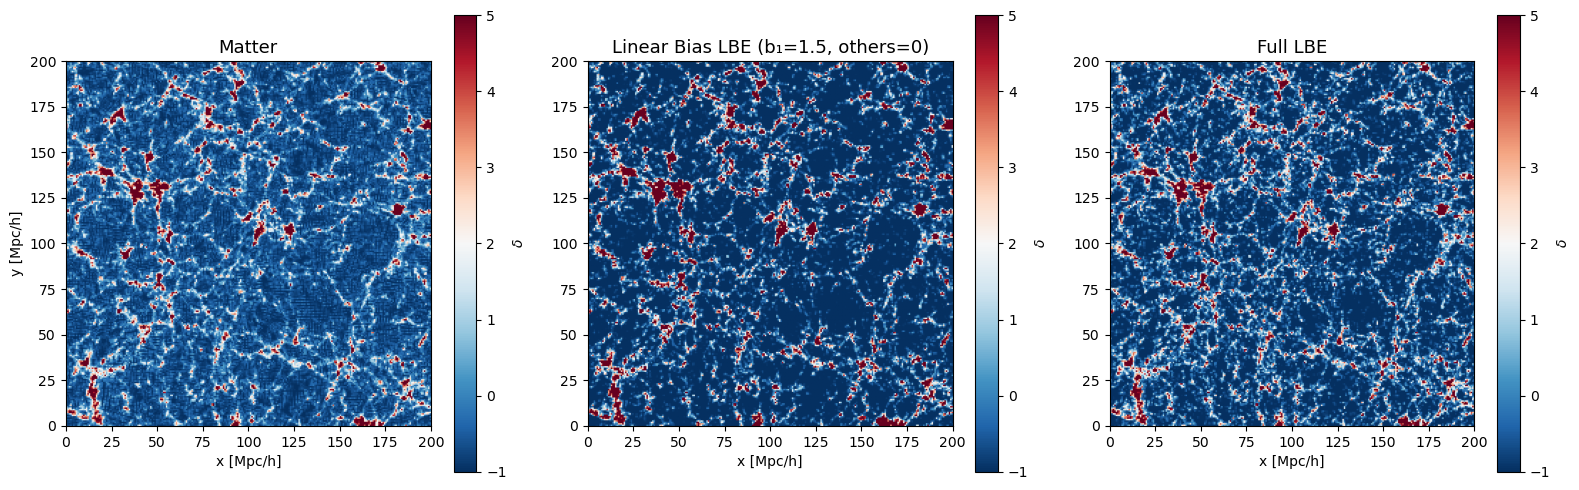

In [9]:
# Visualize bias effects
slice_z = mesh_shape[2] // 2
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
vmin, vmax = -1, 5

titles = ["Matter", "Linear Bias LBE (b₁=1.5, others=0)", "Full LBE"]
fields = [density_matter, density_linear, density_lbe]

for ax, field, title in zip(axes, fields, titles, strict=False):
    im = ax.imshow(
        np.array(field[:, :, slice_z]).T,
        origin="lower",
        cmap="RdBu_r",
        vmin=vmin,
        vmax=vmax,
        extent=[0, box_size, 0, box_size],
    )
    ax.set_title(title, fontsize=13)
    ax.set_xlabel("x [Mpc/h]")
    if ax == axes[0]:
        ax.set_ylabel("y [Mpc/h]")
    plt.colorbar(im, ax=ax, label=r"$\delta$")

plt.tight_layout()
plt.show()

## 4. Redshift-Space Distortions

RSD arises from peculiar velocities projected along the line-of-sight.

In [10]:
# Apply RSD to particle positions
cosmo_rsd = Planck18()
cosmo_rsd._workspace = {}
dpos_rsd = rsd(cosmo_rsd, a_obs, vel_lpt, los=los)
pos_rsd = (pos_lpt + dpos_rsd) % mesh_shape

print("RSD displacement statistics:")
print(f"  Mean: {jnp.mean(jnp.linalg.norm(dpos_rsd, axis=1)):.3f} cells")
print(f"  Max:  {jnp.max(jnp.linalg.norm(dpos_rsd, axis=1)):.3f} cells")

# Paint with and without RSD
density_no_rsd = cic_paint(jnp.zeros(mesh_shape), pos_lpt, weights)
density_no_rsd = density_no_rsd / jnp.mean(density_no_rsd) - 1

density_with_rsd = cic_paint(jnp.zeros(mesh_shape), pos_rsd, weights)
density_with_rsd = density_with_rsd / jnp.mean(density_with_rsd) - 1

print(f"\nNo RSD:   δ ∈ [{jnp.min(density_no_rsd):.2f}, {jnp.max(density_no_rsd):.2f}]")
print(f"With RSD: δ ∈ [{jnp.min(density_with_rsd):.2f}, {jnp.max(density_with_rsd):.2f}]")

RSD displacement statistics:
  Mean: 2.571 cells
  Max:  21.341 cells

No RSD:   δ ∈ [-1.00, 75.01]
With RSD: δ ∈ [-1.00, 53.01]


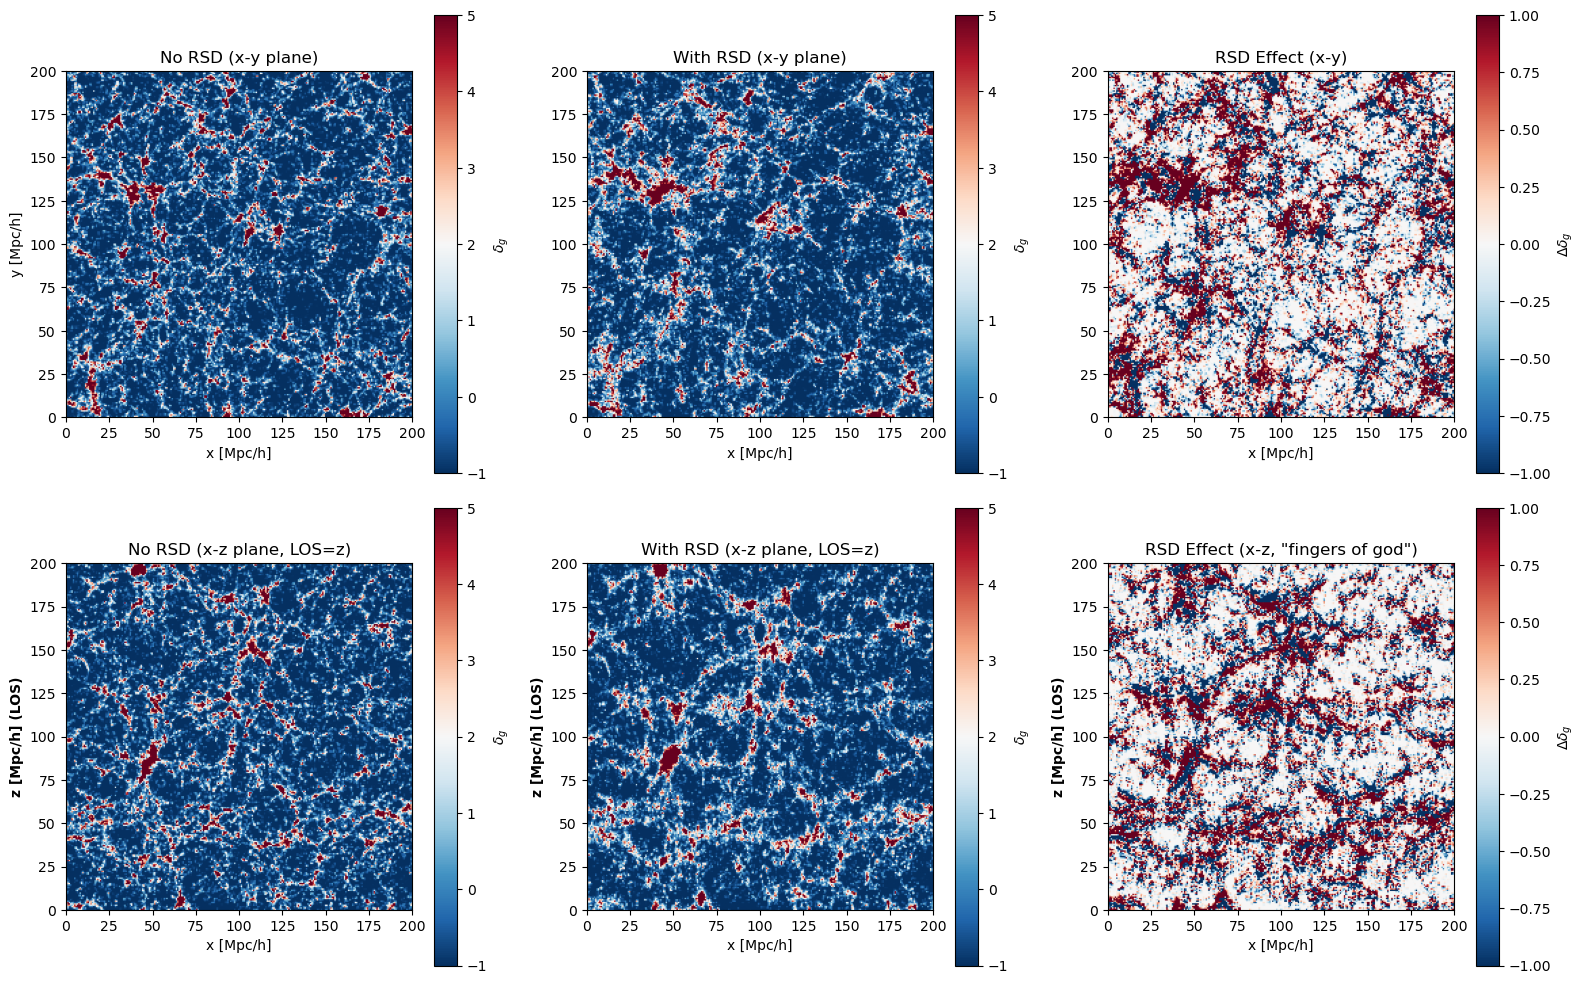


Note: RSD creates elongation along LOS (z-axis) - 'fingers of god' effect


In [11]:
# Visualize RSD effect: compare slices perpendicular and parallel to LOS
fig = plt.figure(figsize=(16, 10))

# Perpendicular to LOS (x-y plane)
slice_xy = mesh_shape[2] // 2
ax1 = plt.subplot(2, 3, 1)
im1 = ax1.imshow(
    np.array(density_no_rsd[:, :, slice_xy]).T,
    origin="lower",
    cmap="RdBu_r",
    vmin=-1,
    vmax=5,
    extent=[0, box_size, 0, box_size],
)
ax1.set_title("No RSD (x-y plane)", fontsize=12)
ax1.set_xlabel("x [Mpc/h]")
ax1.set_ylabel("y [Mpc/h]")
plt.colorbar(im1, ax=ax1, label=r"$\delta_g$")

ax2 = plt.subplot(2, 3, 2)
im2 = ax2.imshow(
    np.array(density_with_rsd[:, :, slice_xy]).T,
    origin="lower",
    cmap="RdBu_r",
    vmin=-1,
    vmax=5,
    extent=[0, box_size, 0, box_size],
)
ax2.set_title("With RSD (x-y plane)", fontsize=12)
ax2.set_xlabel("x [Mpc/h]")
plt.colorbar(im2, ax=ax2, label=r"$\delta_g$")

ax3 = plt.subplot(2, 3, 3)
diff_xy = density_with_rsd - density_no_rsd
im3 = ax3.imshow(
    np.array(diff_xy[:, :, slice_xy]).T,
    origin="lower",
    cmap="RdBu_r",
    vmin=-1,
    vmax=1,
    extent=[0, box_size, 0, box_size],
)
ax3.set_title("RSD Effect (x-y)", fontsize=12)
ax3.set_xlabel("x [Mpc/h]")
plt.colorbar(im3, ax=ax3, label=r"$\Delta\delta_g$")

# Parallel to LOS (x-z plane)
slice_xz = mesh_shape[1] // 2
ax4 = plt.subplot(2, 3, 4)
im4 = ax4.imshow(
    np.array(density_no_rsd[:, slice_xz, :]).T,
    origin="lower",
    cmap="RdBu_r",
    vmin=-1,
    vmax=5,
    extent=[0, box_size, 0, box_size],
)
ax4.set_title("No RSD (x-z plane, LOS=z)", fontsize=12)
ax4.set_xlabel("x [Mpc/h]")
ax4.set_ylabel("z [Mpc/h] (LOS)", fontweight="bold")
plt.colorbar(im4, ax=ax4, label=r"$\delta_g$")

ax5 = plt.subplot(2, 3, 5)
im5 = ax5.imshow(
    np.array(density_with_rsd[:, slice_xz, :]).T,
    origin="lower",
    cmap="RdBu_r",
    vmin=-1,
    vmax=5,
    extent=[0, box_size, 0, box_size],
)
ax5.set_title("With RSD (x-z plane, LOS=z)", fontsize=12)
ax5.set_xlabel("x [Mpc/h]")
ax5.set_ylabel("z [Mpc/h] (LOS)", fontweight="bold")
plt.colorbar(im5, ax=ax5, label=r"$\delta_g$")

ax6 = plt.subplot(2, 3, 6)
diff_xz = density_with_rsd - density_no_rsd
im6 = ax6.imshow(
    np.array(diff_xz[:, slice_xz, :]).T,
    origin="lower",
    cmap="RdBu_r",
    vmin=-1,
    vmax=1,
    extent=[0, box_size, 0, box_size],
)
ax6.set_title('RSD Effect (x-z, "fingers of god")', fontsize=12)
ax6.set_xlabel("x [Mpc/h]")
ax6.set_ylabel("z [Mpc/h] (LOS)", fontweight="bold")
plt.colorbar(im6, ax=ax6, label=r"$\Delta\delta_g$")

plt.tight_layout()
plt.show()

print("\nNote: RSD creates elongation along LOS (z-axis) - 'fingers of god' effect")

## 5. Observational Noise

Real observations have shot noise due to discrete galaxy sampling. We model this by Poisson sampling the galaxy counts in each cell based on the expected mean count.


In [17]:
# Galaxy density and noise level
gxy_density = 1e-3  # galaxies per (Mpc/h)^3
cell_volume = (box_size / mesh_shape[0]) ** 3
gxy_count = gxy_density * cell_volume  # mean galaxies per cell
noise_std = 1.0 / jnp.sqrt(gxy_count)

print(f"Galaxy density: {gxy_density:.1e} gal/(Mpc/h)³")
print(f"Cell volume: {cell_volume:.2f} (Mpc/h)³")
print(f"Mean galaxies per cell: {gxy_count:.3f}")
print(f"Noise std (δ units): {noise_std:.3f}")

signal_field = density_with_rsd
mean_galaxy_field = (1.0 + signal_field) * gxy_count
key_noise = jr.PRNGKey(999)
observed_galaxy_counts = jr.poisson(key_noise, mean_galaxy_field)
density_observed = safe_div(observed_galaxy_counts.astype(float), gxy_count) - 1

print(f"\nTrue field:     δ ∈ [{jnp.min(density_with_rsd):.2f}, {jnp.max(density_with_rsd):.2f}]")
print(f"Observed field: δ ∈ [{jnp.min(density_observed):.2f}, {jnp.max(density_observed):.2f}]")

Galaxy density: 1.0e-03 gal/(Mpc/h)³
Cell volume: 0.48 (Mpc/h)³
Mean galaxies per cell: 0.000
Noise std (δ units): 45.795

True field:     δ ∈ [-1.00, 53.01]
Observed field: δ ∈ [-1.00, 4193.30]


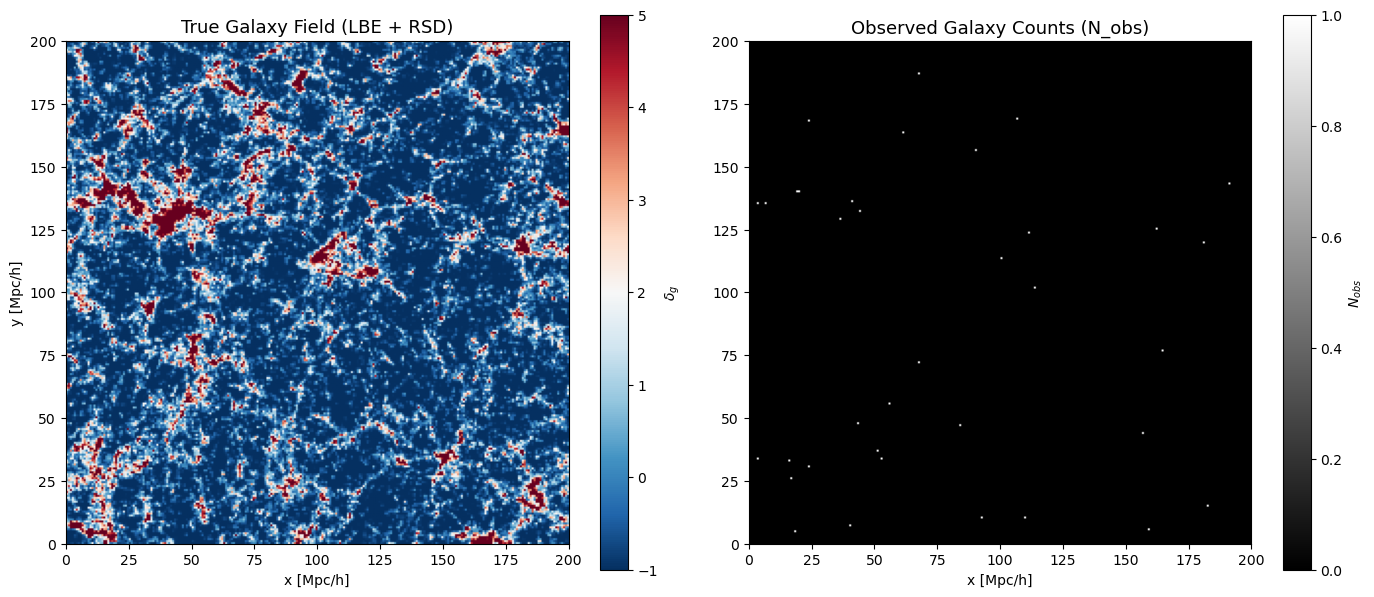

In [23]:
# Visualize noise effect
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

im0 = axes[0].imshow(
    np.array(density_with_rsd[:, :, slice_z]).T,
    origin="lower",
    cmap="RdBu_r",
    vmin=-1,
    vmax=5,
    extent=[0, box_size, 0, box_size],
)
axes[0].set_title("True Galaxy Field (LBE + RSD)", fontsize=13)
axes[0].set_xlabel("x [Mpc/h]")
axes[0].set_ylabel("y [Mpc/h]")
plt.colorbar(im0, ax=axes[0], label=r"$\delta_g$")

im1 = axes[1].imshow(
    np.array(observed_galaxy_counts[:, :, slice_z]).T,
    origin="lower",
    cmap="binary_r",
    vmin=0,
    vmax=1,
    extent=[0, box_size, 0, box_size],
)
axes[1].set_title("Observed Galaxy Counts (N_obs)", fontsize=13)
axes[1].set_xlabel("x [Mpc/h]")
plt.colorbar(im1, ax=axes[1], label=r"$N_{obs}$")

plt.tight_layout()
plt.show()

## 6. Power Spectrum Comparison

Compare power spectra of different models to validate the bias and noise implementation.

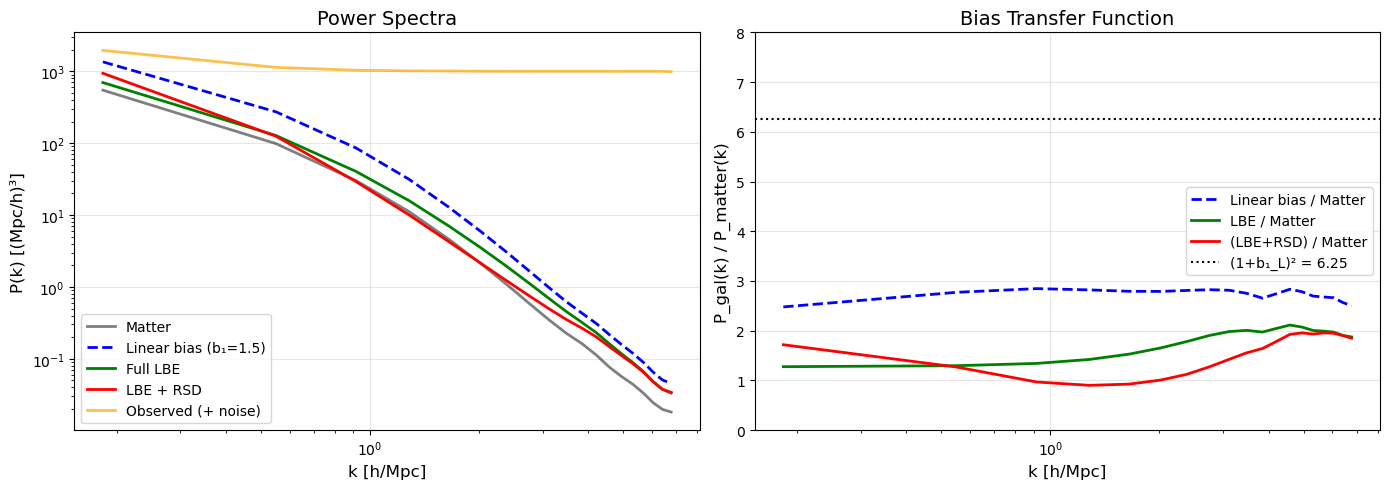

In [24]:
def compute_power_spectrum(field, box_shape):
    """Compute isotropic power spectrum."""
    field_k = jnp.fft.rfftn(field)
    power = jnp.abs(field_k) ** 2

    # Compute k values
    mesh_shape = field.shape
    kx = jnp.fft.fftfreq(mesh_shape[0], d=box_shape[0] / mesh_shape[0]) * 2 * jnp.pi
    ky = jnp.fft.fftfreq(mesh_shape[1], d=box_shape[1] / mesh_shape[1]) * 2 * jnp.pi
    kz = jnp.fft.rfftfreq(mesh_shape[2], d=box_shape[2] / mesh_shape[2]) * 2 * jnp.pi

    kx_grid, ky_grid, kz_grid = jnp.meshgrid(kx, ky, kz, indexing="ij")
    k_mag = jnp.sqrt(kx_grid**2 + ky_grid**2 + kz_grid**2)

    # Bin by k magnitude
    k_bins = jnp.linspace(0, jnp.max(k_mag), 20)
    k_centers = (k_bins[:-1] + k_bins[1:]) / 2

    power_binned = []
    for i in range(len(k_bins) - 1):
        mask = (k_mag >= k_bins[i]) & (k_mag < k_bins[i + 1])
        if jnp.sum(mask) > 0:
            power_binned.append(jnp.mean(power[mask]))
        else:
            power_binned.append(jnp.nan)

    power_binned_normalized = jnp.array(power_binned) * (
        box_shape.prod() / (mesh_shape[0] * mesh_shape[1] * mesh_shape[2]) ** 2
    )
    return k_centers, power_binned_normalized


# Compute power spectra
k, P_matter = compute_power_spectrum(density_matter, box_shape)
k, P_linear = compute_power_spectrum(density_linear, box_shape)
k, P_lbe = compute_power_spectrum(density_lbe, box_shape)
k, P_lbe_rsd = compute_power_spectrum(density_with_rsd, box_shape)
k, P_obs = compute_power_spectrum(density_observed, box_shape)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Power spectra
ax1.loglog(k, P_matter, "k-", alpha=0.5, label="Matter", lw=2)
ax1.loglog(k, P_linear, "b--", label=f"Linear bias (b₁={bias_params['b1']})", lw=2)
ax1.loglog(k, P_lbe, "g-", label="Full LBE", lw=2)
ax1.loglog(k, P_lbe_rsd, "r-", label="LBE + RSD", lw=2)
ax1.loglog(k, P_obs, "orange", alpha=0.7, label="Observed (+ noise)", lw=2)
ax1.set_xlabel("k [h/Mpc]", fontsize=12)
ax1.set_ylabel("P(k) [(Mpc/h)³]", fontsize=12)
ax1.set_title("Power Spectra", fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Ratio to matter (avoid division by zero)
ratio_linear = jnp.where(P_matter > 0, P_linear / P_matter, jnp.nan)
ratio_lbe = jnp.where(P_matter > 0, P_lbe / P_matter, jnp.nan)
ratio_lbe_rsd = jnp.where(P_matter > 0, P_lbe_rsd / P_matter, jnp.nan)

ax2.semilogx(k, ratio_linear, "b--", label="Linear bias / Matter", lw=2)
ax2.semilogx(k, ratio_lbe, "g-", label="LBE / Matter", lw=2)
ax2.semilogx(k, ratio_lbe_rsd, "r-", label="(LBE+RSD) / Matter", lw=2)
bE_sq = (1 + bias_params["b1"]) ** 2
ax2.axhline(y=bE_sq, color="k", linestyle=":", label=f"(1+b₁_L)² = {bE_sq:.2f}")
ax2.set_xlabel("k [h/Mpc]", fontsize=12)
ax2.set_ylabel("P_gal(k) / P_matter(k)", fontsize=12)
ax2.set_title("Bias Transfer Function", fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0, 8])

plt.tight_layout()
plt.show()

## 7. Summary

✅ **Validated:**
- Kaiser model provides simple linear bias + RSD.
- Lagrangian bias expansion (LBE) captures non-linear bias effects.
- RSD creates anisotropy (Kaiser effect at these scales).
- Observational noise (Poisson) is correctly implemented.

**Key findings:**
- **Linear bias:** The power spectrum follows $P_{\text{gal}}(k) \approx (1+b_1)^2 P_{\text{matter}}(k)$ at large scales (using $b_1$ as the Lagrangian bias).
- **Higher-order bias:** LBE terms (b₂, bs2, bn2) modify small-scale clustering.
- **RSD:** Enhances clustering along the line-of-sight.
- **Noise:** The Poisson shot noise correctly adds a white noise floor of $P_{\text{noise}} = 1 / \bar{n}$.

**Model Limitations:**
- **Non-physical Model:** The polynomial LBE model is non-physical as it predicts negative weights ($w < 0$).
- **"Clipping" Patch:** We applied a `jnp.maximum(0.0, ...)` patch to force $w \ge 0$. This is an *ad-hoc fix*, not real physics.
- **Power Suppression:** This patch artificially **suppresses power** in voids. This is why the measured $P_{\text{gal}}(k)$ in the plot is slightly *below* the naive $(1+b_1)^2$ prediction.
- **Biased Results:** Using this patched, physically incorrect model to analyze real data (like DESI) would produce **biased cosmological parameters**. This model is only valid for *technical tests* of the inference code.